In [12]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


/Users/maxvazquez/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [109]:
from elo_mmr_py import Contest, rate

contests = [
    Contest(standings=[('player_1', 2, 2), ('player_2', 4, 4), ('player_3', 20, 20)]),
    Contest(standings=[('player_1', 0, 1), ('player_2', 0, 1), ('player_3', 2, 2)]),
    Contest(standings=[('player_1', 0, 0), ('player_2', 1, 2), ('player_3', 1, 2)]),
    Contest(standings=[('player_4', 0, 0), ('player_1', 1, 1), ('player_2', 2, 2), ('player_3', 3, 3)]),
    Contest(standings=[('player_4', 0, 0), ('player_1', 1, 1), ('player_2', 2, 2), ('player_3', 3, 3)]),
]
r = rate(contests)
r['player_3']

Player(name='player_3', rating=1294, events=[PyPlayerEvent(contest_index=1, rating_mu=1295, rating_sig=171, perf_score=1256, place=2), PyPlayerEvent(contest_index=2, rating_mu=1343, rating_sig=130, perf_score=1395, place=1), PyPlayerEvent(contest_index=3, rating_mu=1311, rating_sig=111, perf_score=1251, place=3), PyPlayerEvent(contest_index=4, rating_mu=1294, rating_sig=100, perf_score=1253, place=3)])

In [14]:
r['player_1'].events[0].rating_sig

171

In [74]:
headers = {
    'X-Csrf-Token': 'QsiFWuxEY1S9h_-dQgRA_7S5w9uvvmXsjq56QbTPw4i_g_XR68rMCBFFhW6HngBRtHskfN5yjX8GQmawqs8BlQ',
    'Referer': 'https://ifsc.results.info',
    'Cookie': 'session_id=_verticallife_resultservice_session=6RHN3xZrXnftTiScNfSHg7BVvuebLzGAmC9P5vIpzdySn2vG7VwQpjSZRDHug%2BPKCWlkt831HjLvHsPoVKrzTGsPVR6mqSOtjHB%2Bwht%2Bj39KxYO%2FJlaU6zmh8VhNFEl9bXHiOlPGk8AxnZqiBSYKTxJFCqh34nqdurXfFDcsRnbEtYCixcOdx%2F32E4zYGLVw7DSXXIKOVTUivS43UJZq5zDWPctX95UWm%2FD7%2B6UYT2s0B%2B3XJVPgjMWCMR%2FVZs%2FQC45Gjm4uCpHHe8Yt73nM3J%2Br43V1HuHGSvRpRczrJ4QdovlJHDEpg4rjUA%3D%3D--xlV%2BnBWvX%2BFwNcXI--24wJLAwE%2F8YbvCRvH9nMWQ%3D%3D',  # If session cookies are required
}
#url = f"https://ifsc.results.info//api/v1/category_rounds/8508/results"
url = f"https://ifsc.results.info/api/v1/athletes/2033"
#url = f"https://ifsc.results.info/api/v1/events/1294/result"
#url = "https://ifsc.results.info/api/v1/events/1355/result/3"


response = requests.get(url, headers=headers)
if response.status_code == 200:
    test = response.json()
test

{'id': 2033,
 'firstname': 'Jabee',
 'lastname': 'KIM',
 'birthday': '1987-02-13',
 'gender': 'male',
 'paraclimbing_sport_class': None,
 'sport_class_status': None,
 'sport_class_review_date': None,
 'pronouns': None,
 'personal_story': None,
 'federation': {'id': 21,
  'name': 'Korea Alpine Federation',
  'abbreviation': 'KAF',
  'url': 'https://kaf.or.kr'},
 'speed_personal_best': {'time': '7.97',
  'date': '2019-08-21',
  'event_name': 'IFSC Climbing World Championships - Hachioji (JPN) 2019',
  'round_name': 'Qualification'},
 'country': 'KOR',
 'flag_url': 'https://d1n1qj9geboqnb.cloudfront.net/flags/KOR.png',
 'city': 'Ganbuk-gu, Seoul',
 'age': 37,
 'arm_span': None,
 'height': None,
 'favourite_movie': None,
 'favourite_game': None,
 'favourite_song': None,
 'sporting_hero': None,
 'hobby': None,
 'website': None,
 'instagram': None,
 'twitter': None,
 'facebook': None,
 'youtube': None,
 'nickname': None,
 'residence': None,
 'spoken_languages': None,
 'coach': None,
 'photo_

## Data Loading and Cleaning

In this section we remove some improbable outliers and filter to only look at able-bodied climbers; there is a larger amount of data for this group and so our analysis may be more fruitful.

In [16]:
athlete_info = pd.read_csv('athlete_information.csv')
athlete_results = pd.read_csv('athlete_results.csv')

In [17]:
athlete_results.isnull().sum()

athlete_id          0
rank                0
discipline          0
season              0
date                0
event_id            0
event_location    798
d_cat               0
dtype: int64

In [18]:
athlete_info.isnull().sum()

athlete_id                      0
firstname                       0
lastname                        1
age                          7262
gender                          0
country                         0
height                      15306
arm_span                    15901
paraclimbing_sport_class    15743
birthday                     7262
dtype: int64

In [19]:
# Convert object type columns to string (except for birthday)
for col in ['firstname', 'lastname', 'gender', 'country', 'paraclimbing_sport_class']:
    athlete_info[col] = athlete_info[col].astype(str)

athlete_info['birthday'] = pd.to_datetime(athlete_info['birthday'].str[:10], format='%Y-%m-%d')


for col in ['discipline', 'event_location']:
    athlete_results[col] = athlete_results[col].astype(str)

athlete_results['date'] = pd.to_datetime(athlete_results['date'].str[:10], format='%Y-%m-%d')


In [20]:
able_bodied = athlete_info[athlete_info['paraclimbing_sport_class'] == 'nan'].copy()
able_bodied[['height', 'arm_span', 'age']].describe()

,height,arm_span,age
count,816.000000,299.000000,8481.000000
mean,170.851716,170.889632,27.619149
std,56.187952,102.294406,11.716531
min,1.000000,-1.000000,4.000000
25%,164.000000,166.000000,19.000000
50%,170.000000,177.000000,24.000000
75%,176.000000,183.000000,33.000000
max,1710.000000,1780.000000,124.000000


In [21]:
able_bodied.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15743 entries, 2 to 16255
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   athlete_id                15743 non-null  int64         
 1   firstname                 15743 non-null  object        
 2   lastname                  15743 non-null  object        
 3   age                       8481 non-null   float64       
 4   gender                    15743 non-null  object        
 5   country                   15743 non-null  object        
 6   height                    816 non-null    float64       
 7   arm_span                  299 non-null    float64       
 8   paraclimbing_sport_class  15743 non-null  object        
 9   birthday                  8481 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 1.3+ MB


There are clearly some insane outliers for height and arm_span that we should remove. By visualizing the histograms of these columns with frequency on a log scale, we can get a better understanding of these outliers.

In [22]:
# drop athletes with height or arm span greater than 1000
able_bodied = able_bodied[(able_bodied['height'].isnull()) | (able_bodied['height'] < 1000)]
able_bodied = able_bodied[(able_bodied['arm_span'].isnull()) | (able_bodied['arm_span'] < 1000)]

# drop athletes with height or arm span less than 100
able_bodied = able_bodied[(able_bodied['height'].isnull()) | (able_bodied['height'] > 100)]
able_bodied = able_bodied[(able_bodied['arm_span'].isnull()) | (able_bodied['arm_span'] > 100)]



In [23]:
athlete_results = athlete_results[athlete_results['athlete_id'].isin(able_bodied['athlete_id'])]
athlete_results = athlete_results[athlete_results['rank'] < 999]

athlete_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132343 entries, 20 to 135088
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   athlete_id      132343 non-null  int64         
 1   rank            132343 non-null  int64         
 2   discipline      132343 non-null  object        
 3   season          132343 non-null  int64         
 4   date            132343 non-null  datetime64[ns]
 5   event_id        132343 non-null  int64         
 6   event_location  132343 non-null  object        
 7   d_cat           132343 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 9.1+ MB


In [24]:
athlete_results = pd.merge(
    athlete_results,               # Left DataFrame (results will stay the same)
    able_bodied[['athlete_id', 'gender', 'age', 'country']],  # Only 'athlete_id' and 'gender' from the right DataFrame
    on='athlete_id',                  # Merge on the common column 'athlete_id'
    how='left'                        # Use a left join to keep all rows from athlete_results_df
)


athlete_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132343 entries, 0 to 132342
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   athlete_id      132343 non-null  int64         
 1   rank            132343 non-null  int64         
 2   discipline      132343 non-null  object        
 3   season          132343 non-null  int64         
 4   date            132343 non-null  datetime64[ns]
 5   event_id        132343 non-null  int64         
 6   event_location  132343 non-null  object        
 7   d_cat           132343 non-null  int64         
 8   gender          132343 non-null  object        
 9   age             90215 non-null   float64       
 10  country         132343 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 11.1+ MB


## Basic EDA

We can begin by looking at some histograms of our athlete information data. One of particular interest is the so called 'ape-index', which is computed as arm_span/height. Many climbers look at a higher ape index as an advantage, as it means the climber has a longer reach proportionally.

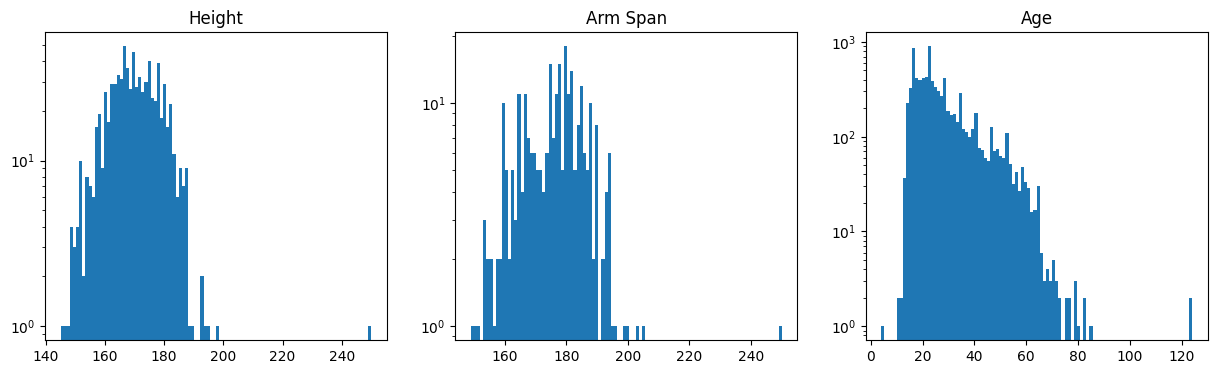

In [25]:
# seperate plots of arm_span and height
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].hist(able_bodied['height'], bins=100)
ax[0].set_title('Height')
ax[0].set_yscale('log')

ax[1].hist(able_bodied['arm_span'], bins=100)
ax[1].set_title('Arm Span')
ax[1].set_yscale('log')

ax[2].hist(able_bodied['age'], bins=100)
ax[2].set_title('Age')
ax[2].set_yscale('log')


plt.show()


### Ape Index

Below we find that average ape index for both genders is above 1.02, which is mostly in agreement with this study on the anthropometry of competitive climbers. Keep in mind this is with a small sample size, as most athletes have null height and arm_span fields. For further reading on the anthropometry of young competitive sport climbers, see Watts, P., Joubert, L., Lish, A., Mast, J.D., & Wilkins, B. (2003). *Anthropometry of young competitive sport rock climbers*. British Journal of Sports Medicine, 37(5), 420–424. https://doi.org/10.1136/bjsm.37.5.420 [Link to full paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1751349/pdf/v037p00420.pdf)

Later on we can check for any correlation of ape index with performance, and compare our results with the afformentioned paper.


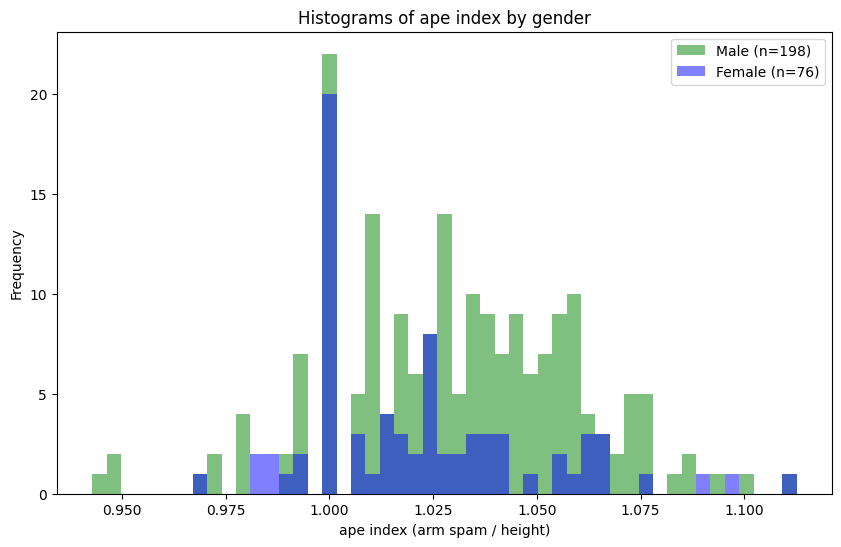

In [26]:
able_bodied['ape_index'] = able_bodied['arm_span'] / able_bodied['height']
# histogram of ape index
data_0 = able_bodied[able_bodied['gender'] == 'male']['ape_index']
data_1 = able_bodied[able_bodied['gender'] == 'female']['ape_index']

bin_min = min(data_0.min(), data_1.min())
bin_max = max(data_0.max(), data_1.max())
bins = np.linspace(bin_min, bin_max, 50)  

# Plot the histograms
plt.figure(figsize=(10, 6))
plt.hist(data_0, alpha=0.5, label=f'Male (n={data_0.notna( ).sum()})', bins=bins, color='green')
plt.hist(data_1, alpha=0.5, label=f'Female (n={data_1.notna( ).sum()})', bins=bins, color='blue')

# Add labels and title
plt.xlabel('ape index (arm spam / height)')
plt.ylabel('Frequency')
plt.title(f'Histograms of ape index by gender')
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [27]:
desc_data_0 = data_0.describe().to_frame(name='Male')
desc_data_1 = data_1.describe().to_frame(name='Female')
desc_overall = able_bodied['ape_index'].describe().to_frame(name='Overall')
summary_stats = pd.concat([desc_data_0, desc_data_1, desc_overall], axis=1)
summary_stats

,Male,Female,Overall
count,198.000000,76.000000,274.000000
mean,1.029748,1.022362,1.027699
std,0.028905,0.028646,0.028971
min,0.942857,0.969697,0.942857
25%,1.011236,1.000000,1.001381
50%,1.029241,1.018693,1.027397
75%,1.050705,1.036924,1.047549
max,1.110429,1.112583,1.112583


As part of our cleaning we should drop duplicate results for an athlete in a competition.

In [99]:
pd.set_option('display.max_rows', 100)

duplicates = athlete_results[athlete_results.duplicated(subset=['event_id', 'athlete_id', 'discipline'], keep=False)].sort_values(by=['athlete_id'])
duplicates.head(100)

AttributeError: 'NoneType' object has no attribute 'duplicated'

In [98]:
athlete_results = athlete_results[~athlete_results.duplicated(subset=['event_id', 'athlete_id', 'discipline'], keep=False)]

<class 'pandas.core.frame.DataFrame'>
Index: 132175 entries, 0 to 132342
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   athlete_id      132175 non-null  int64         
 1   rank            132175 non-null  int64         
 2   discipline      132175 non-null  object        
 3   season          132175 non-null  int64         
 4   date            132175 non-null  datetime64[ns]
 5   event_id        132175 non-null  int64         
 6   event_location  132175 non-null  object        
 7   d_cat           132175 non-null  int64         
 8   gender          132175 non-null  object        
 9   age             90109 non-null   float64       
 10  country         132175 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 12.1+ MB


## Normalized rankings

A useful metric might me normalized ranking, computed by rank / number of participants - A rank of 5 out of 100 is more impressive than a rank of 5 out of 10. First we must determine how to seperate competitions. If we group by by event_id, discipline, gender, and d_cat then we have an individual competition. We can double check this by checking that number of participants, as computed by the number of rows per group is about the same as the lowest rank seen in that group.

In [64]:
comps_grp = athlete_results.groupby(['event_id', 'd_cat', 'discipline']).agg(
    lowest_rank=('rank', 'max'),    
    num_participants=('rank', 'size') 
).reset_index()

In [62]:
comps_grp.describe()

,event_id,d_cat,lowest_rank,num_participants
count,4242.000000,4242.000000,4242.000000,4242.000000
mean,786.881895,178.247760,31.088873,31.198256
std,370.967603,153.363859,22.069949,22.431169
min,65.000000,1.000000,1.000000,1.000000
25%,452.000000,7.000000,14.000000,14.000000
50%,827.000000,227.500000,26.000000,26.500000
75%,1081.000000,253.000000,43.000000,43.000000
max,1396.000000,752.000000,152.000000,166.000000


In [65]:
comps_grp.describe()

,event_id,d_cat,lowest_rank,num_participants
count,4238.000000,4238.000000,4238.000000,4238.000000
mean,787.099339,178.306277,31.099339,31.227702
std,371.023177,153.394996,22.071959,22.422527
min,65.000000,1.000000,1.000000,1.000000
25%,452.000000,7.000000,14.000000,14.000000
50%,827.000000,229.000000,26.000000,27.000000
75%,1081.000000,253.000000,43.000000,43.000000
max,1396.000000,752.000000,152.000000,166.000000


### Competitions that have multiple gender participants?

In [68]:
multiple_genders = athlete_results.groupby(['event_id', 'd_cat'])['gender'].nunique()

# Filter for groups with more than 1 unique value
filtered_groups = multiple_genders[multiple_genders > 1]
filtered_groups.head()

event_id  d_cat
289       33       2
433       5        2
752       213      2
          214      2
Name: gender, dtype: int64

In [85]:
athlete_results.query('event_id == 361 & d_cat == 413').sort_values(by='rank')

,athlete_id,rank,discipline,season,date,event_id,event_location,d_cat,gender,age,country
74840,4535,1,lead,2004,2004-11-12,361,Brno,413,female,NaN,SUI
80155,4756,2,lead,2004,2004-11-12,361,Brno,413,female,NaN,UKR
22439,1121,3,lead,2004,2004-11-12,361,Brno,413,female,38.0,SLO
26253,1207,4,lead,2004,2004-11-12,361,Brno,413,female,38.0,AUT
6212,306,5,lead,2004,2004-11-12,361,Brno,413,female,50.0,BEL
45070,2251,6,lead,2004,2004-11-12,361,Brno,413,female,36.0,JPN
8655,438,7,lead,2004,2004-11-12,361,Brno,413,female,39.0,FRA
76924,4702,8,lead,2004,2004-11-12,361,Brno,413,female,NaN,UKR
41936,2035,9,lead,2004,2004-11-12,361,Brno,413,female,36.0,KOR
89576,5464,10,lead,2004,2004-11-12,361,Brno,413,female,NaN,RUS


Correlation between number of participants and lowest rank: 0.9969542486925016


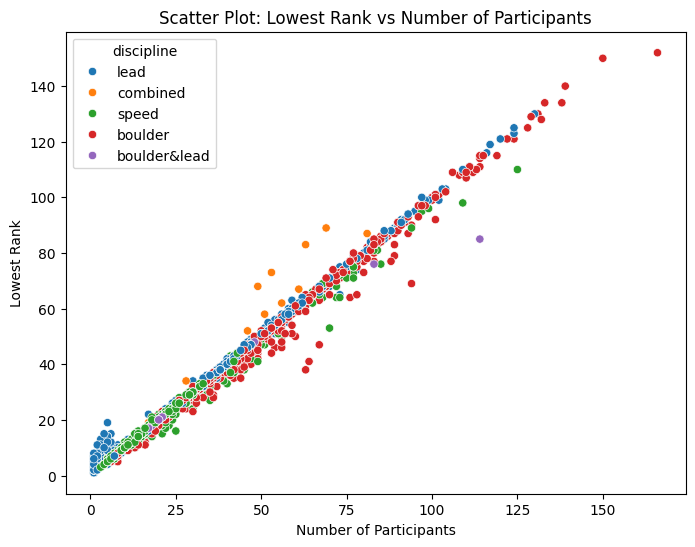

In [66]:
print(f"Correlation between number of participants and lowest rank: {comps_grp['lowest_rank'].corr(comps_grp['num_participants'])}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x='num_participants', y='lowest_rank', data=comps_grp, hue='discipline')

# Adding labels and title
plt.xlabel('Number of Participants')
plt.ylabel('Lowest Rank')
plt.title('Scatter Plot: Lowest Rank vs Number of Participants')

# Show the plot
plt.show()

To remove some outlier noise we can use the first PCA component as the denominator for our computation of normalized rank.

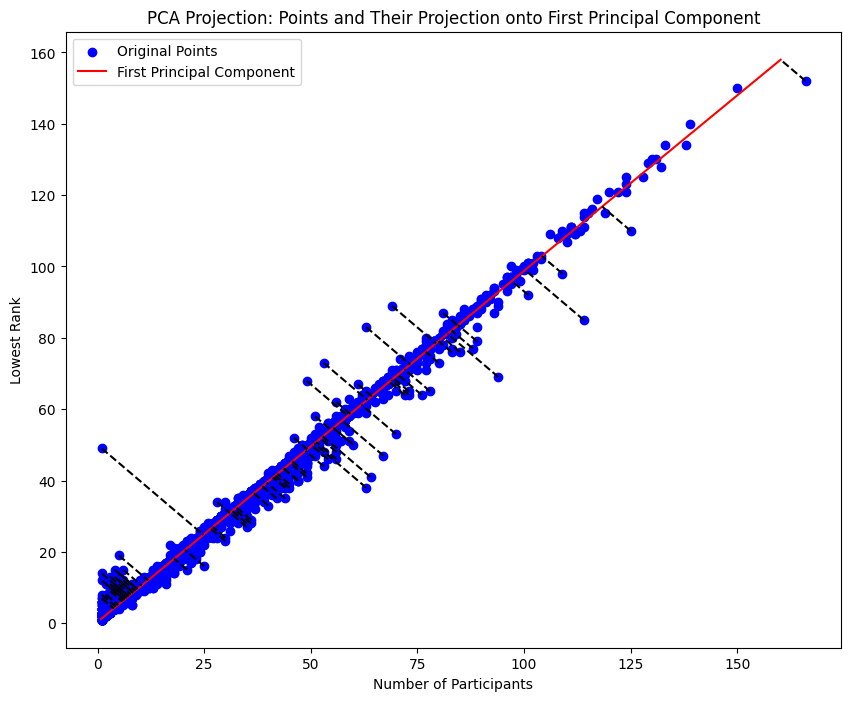

In [31]:
pca = PCA(n_components=2)
principal_component = pca.fit_transform(comps_grp[['num_participants', 'lowest_rank']])

comps_grp['PC1'] = principal_component[:, 0]
comps_grp['PC2'] = principal_component[:, 1]

t = 4
large_pc2 = comps_grp['PC2'].abs() > t

plt.figure(figsize=(10, 8))
plt.scatter(comps_grp['num_participants'], comps_grp['lowest_rank'], color='blue', label='Original Points')

pc1_min, pc1_max = comps_grp['PC1'].min(), comps_grp['PC1'].max()
line_points = np.array([pc1_min, pc1_max])
line_points_original_space = pca.inverse_transform(np.column_stack((line_points, np.zeros_like(line_points))))
# Plot the first principal component
plt.plot(line_points_original_space[:, 0], line_points_original_space[:, 1], color='red', label='First Principal Component')

for index, row in comps_grp[large_pc2].iterrows():
    original_point = np.array([row['num_participants'], row['lowest_rank']])
    projection_onto_pc1 = pca.inverse_transform([row['PC1'], 0])  # Project onto the first PC

    # Plot the projection line
    plt.plot([original_point[0], projection_onto_pc1[0]], [original_point[1], projection_onto_pc1[1]], 'k--')

# Step 7: Add labels and legend
plt.xlabel('Number of Participants')
plt.ylabel('Lowest Rank')
plt.title('PCA Projection: Points and Their Projection onto First Principal Component')
plt.legend()
plt.show()

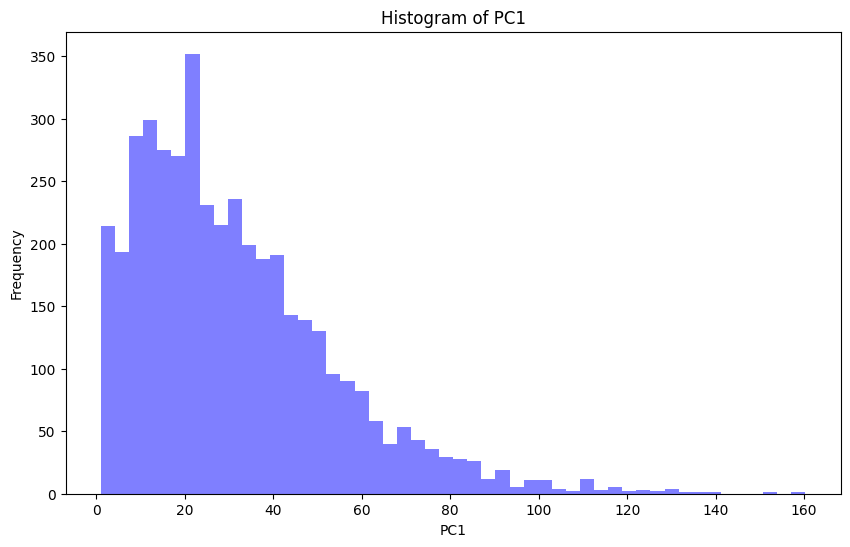

In [55]:

# Scale first PC to match distribution of number of participants and lowest rank
denominator = comps_grp['PC1'] +1 - comps_grp['PC1'].min()
denominator = denominator * (160 / denominator.max()) + 1 - (160 / denominator.max())


plt.figure(figsize=(10, 6))
plt.hist(denominator, bins=50, color='blue', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('Frequency')
plt.title('Histogram of PC1')
plt.show()

In [63]:
denominator.sort_values(ascending=True)[:60]


2250    1.000000
2211    1.000000
2249    1.000000
2691    1.000000
2688    1.000000
2687    1.000000
2241    1.000000
1821    1.000000
2000    1.000000
2007    1.000000
2008    1.000000
2234    1.000000
2233    1.000000
2009    1.000000
2251    1.000000
2010    1.000000
2228    1.000000
2227    1.000000
2226    1.000000
2013    1.000000
2223    1.000000
2221    1.000000
2580    1.000000
2579    1.000000
2216    1.000000
2215    1.000000
2214    1.000000
2114    1.000000
2577    1.000000
2011    1.000000
2253    1.000000
2210    1.000000
2772    1.000000
2413    1.000000
1621    1.000000
2414    1.000000
1613    1.000000
1623    1.000000
2403    1.000000
2412    1.000000
2417    1.000000
2400    1.000000
1615    1.000000
2775    1.000000
2398    1.000000
2396    1.000000
2395    1.000000
2254    1.000000
2411    1.000000
3076    1.499787
2582    1.499787
2401    1.499787
2578    1.499787
2014    1.499787
2803    1.499787
1618    1.499787
2231    1.499787
2236    1.499787
2415    1.4997

In [46]:

line_points_original_space = pca.inverse_transform(np.column_stack((comps_grp['PC1'], np.zeros_like(comps_grp['PC1']))))


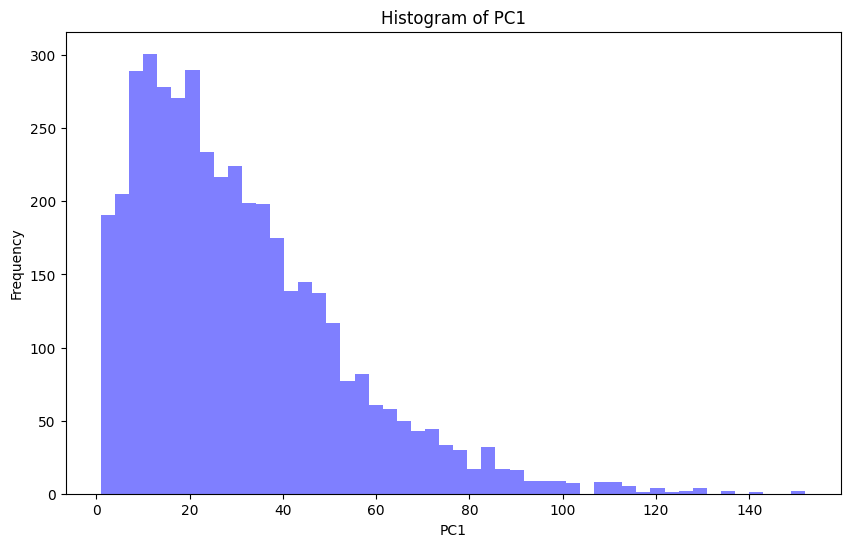

In [52]:


idk = np.sqrt(np.power(line_points_original_space[:, 1], 2) + np.power(line_points_original_space[:, 0], 2))

plt.figure(figsize=(10, 6))
plt.hist(comps_grp['lowest_rank'], bins=50, color='blue', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('Frequency')
plt.title('Histogram of PC1')
plt.show()